# 0. Foreword

<center><a href="https://twitter.com/emilymbender/status/1067108757488848896?ref_src=twsrc%5Etfw"><img src="img/bender.png" /></a></blockquote></center>


### 1. All datasets are in German
### 2. All links are to open access journals _only_

---

# 1. Prerequisites

Neural networks have four building blocks that define how the network operates and how it is trained. As the network architectures have become increasingly complex the details of how the networks are trained have similarly increased, how large the mini batches are, what optimizer to use etc. For instance, see [_RoBERTa: A Robustly Optimized BERT Pretraining Approach_](https://arxiv.org/abs/1907.11692).

The four main components of a trained neural network are

- the network architecture
    - feed forward, recurrent, transformer?
    - how many layers?
    - how wide are the layers?
    
    
- the optimizer
    - SGD
    - Adam
    - AdamW
    
    
- the scheduler
    - constant
    - slanted learning rates
    
    
- the learning objective and loss function
    - this is problem dependent
    - masked language model (MLM)
    - causal language model (CLM)
    - translation language model (TLM)
    - classification

https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html


## 1.1 Network Architecture

The networks architecture is perhaps the most visible part of the four. It defines how the individual (artificial) neurons work and how they connect together. At its simplest the network is a fully connected feed forward network with sigmoid as the activation function for the neurons.

In [41]:
import torch
from torch import nn
from torch.nn import functional as F

class FeedForward(nn.Module):
    def __init__(self, layers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # create feed forward layers
        self.layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features)
                                     for (in_features, out_features) in layers])
        
        # TODO: initialise weights
        
        # create activation functions for each layer
        self.activation = torch.nn.Sigmoid()

    def forward(self, X):
        output = None
        for i_layer, layer in enumerate(self.layers):
            if output is None:
                output = self.activation(layer(X))
            else:
                output = self.activation(layer(output))
        # do softmax
        log_prob = F.log_softmax(output, dim=1)
        return log_prob


n_classes = 2
n_features = 50
layer_spec = [(n_features, 25), (25, n_classes)]

ff = FeedForward(layers=layer_spec)
inputs = torch.randn((10, n_features), dtype=torch.float32)
ff(inputs).exp().detach().numpy()

array([[0.53555024, 0.46444976],
       [0.5452539 , 0.45474613],
       [0.53483075, 0.46516922],
       [0.5373183 , 0.46268165],
       [0.54786193, 0.45213804],
       [0.5346192 , 0.46538073],
       [0.5340415 , 0.46595848],
       [0.54175943, 0.45824063],
       [0.5443332 , 0.45566675],
       [0.54532367, 0.45467633]], dtype=float32)

--- 

## 1.2 Optimizer and Scheduler

- Sebastian Ruder: [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/) January 2016

## Stochastic Gradient Descent

- update network parameters by a fraction _learning rate_ after each example


## Mini-batch Gradient Descent

- update network parameters by a fraction _learning rate_ after each mini-batch of size $ n>1 $

## 1.3 Training the Network

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X, y = make_blobs(n_samples=500, n_features=n_features, centers=2)
X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
sampler = RandomSampler(train_dataset)

# Utilize the data loader from pytorch to create batches of data 
train_data = DataLoader(train_dataset, sampler=sampler, batch_size=8)

### 1.3.1 A Learning Function
Define a training function that loops through the training data some number of times and updates the model weights as well as the learning rate schedule.

__Note__ that each iteration over the inner for loop takes _one batch_ of data from the `pytorch` data loader class. The batch size determines how much data is used to compute the gradient. ___This will become important later!___


In [52]:
def train_model(model: nn.Module,
                data: DataLoader,
                criterion: nn.modules.loss._Loss,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler,
                n_epochs: int = 1):
    model.train()
    losses = []
    # for each epoch
    for i_epoch in range(n_epochs):
        optimizer.zero_grad()
        train_loss = 0
        # go through the training data one batch at a time
        for x_, y_ in data:
            # Forward pass
            y_pred = model(x_)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_)
            train_loss += loss.item() / i_step
            
            # Backprop loss
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update learning rate schedule
            scheduler.step()
            
            optimizer.zero_grad()
        losses.append(train_loss)
    return model, losses

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

model = FeedForward(layer_spec)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
scheduler = LambdaLR(optimizer, lambda epoch: 1e-3)

trained_model, losses_sgd = train_model(model, train_data, criterion, optimizer, scheduler, n_epochs=50)

model = FeedForward(layer_spec)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
trained_model, losses_sgd_momentum = train_model(model, train_data, criterion, optimizer, scheduler, n_epochs=50)

model = FeedForward(layer_spec)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
trained_model, losses_adam = train_model(model, train_data, criterion, optimizer, scheduler, n_epochs=50)

The choice of optimizer makes quite a difference. As the network becomes larger (more parameters) and the problme more complex the optimizer becomes increasingly important.

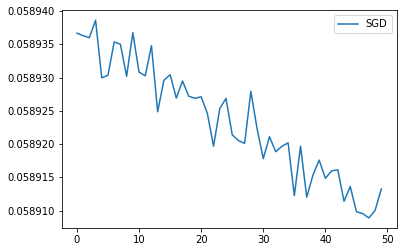

In [59]:
%matplotlib inline

plt.plot(losses_sgd, label='SGD');
plt.legend();

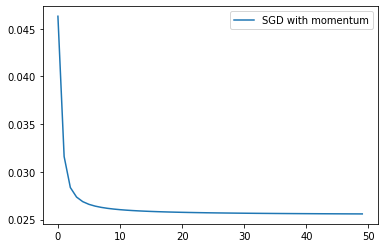

In [60]:
%matplotlib inline

plt.plot(losses_sgd_momentum, label='SGD with momentum');
plt.legend();

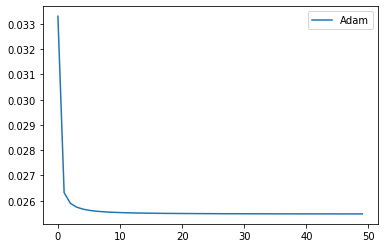

In [61]:
plt.plot(losses_adam, label='Adam');
plt.legend();

---

# 1.4 Natural Language (text) to Linear Algebra

The dummy data set we used in the previous section was already vectors so that no work was required to transform the data into something (a vector) a neural network can consume. Natural langauge text, or `python` source code for that matter, does not come in this readily available form so some amount of preprocessing is required.

The great promise of artificial neural networks for NLP is that a lot of the feature engineering work that has in the past been done by arduous PhD students can be offloaded to the combination of neural network machinery, gradient descent and the loss function to be minimised. Optimising a loss function given some training data may lead to problems down the line in the networks ability to [generalise to other kinds of data](https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/), but we'll forego that concern here.

## 1.4.1 Representing Natural Language - a Computer Science Perspective

Natural languages are ambiguous, complex and highly expressive ways of encoding information, not just semantics but also a lot of cultural details like class hierarchies and history. The Viking conquests are present in the everyday usage of english. We grow _cows_ _pigs_ and _lamb_ but eat _beef_ _pork_ and _mutton_, at least the non-vegetarians do. In finnish _vasta_ and _vihta_ refer to a collection of young leafy birch branches used when bathing (sauna), however _vihta_ is only ever used in western Finland and _vasta_ only in eastern Finland. Whether or not these etymological tidbits and subtle differences in the semantics of the words are necessary or even helpful in solving some task remains debatable.

Word vectors, also known as _embeddings_, aim to create word representations that capture distributional similarity between words as vectors. Specifically, the word vectors should act in such a way that algebraic modifications maintain the semantic coherence. By capturing distributional similarity they end up capturing semantic information about words and their relations and thus allow for a somewhat coherent way of encoding natural language text into vectors.

These vectors can be used to encode documents for neural networks.

## 1.4.2 A Text Classifier with Embeddings

Below, we'll use the fastText word embeddings to create a document classifier for the "_10k German News Articles Dataset_" (GNAD) data set.

In [2]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1218M  100 1218M    0     0  9140k      0  0:02:16  0:02:16 --:--:-- 9750k75k      0  0:02:20  0:01:02  0:01:18 9744k:02:16  0:02:14  0:00:02 9153k16  0:02:16 --:--:-- 9326k


In [15]:
!curl -O https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.2M  100 23.2M    0     0  5399k      0  0:00:04  0:00:04 --:--:-- 5400k 0:00:01  0:00:08 2573k


In [16]:
!curl -O https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2690k  100 2690k    0     0  1679k      0  0:00:01  0:00:01 --:--:-- 1679k


In [53]:
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 14.9MB 3.1MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.0-cp37-none-any.whl size=14912286 sha256=5de6ce5f915611662cf498cdfe4f0ccd43ff647bc3068abb6902928b045e5686
  Stored in directory: /private/var/folders/v0/zh1ybpwd1xgb9mrkp8mw1zsr0000gn/T/pip-ephem-wheel-cache-fztoq3uc/wheels/71/3d/6c/0e841e5195cedb751569abff1815e5d890f2c44e72849d3da8
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


---

# Word Vectors

In [6]:
from gensim.models import KeyedVectors
ft_vec = KeyedVectors.load_word2vec_format('cc.de.300.vec.SMALL.gz')

Much has been said about word vectors, and as a result I won't go into a lot of detail here, but instead simply refer to the existing excellent resources that are already available.

- Noah Smith: [Contextual Word Representations: A Contextual Introduction](https://arxiv.org/abs/1902.06006)


- Mikolov et al.: [_Efficient Estimation of Word Representations in Vector Space._](http://arxiv.org/abs/1301.3781) ICLR (Workshop Poster) 2013

  > "_We propose two novel model architectures for computing continuous vector representations of words from very large data sets. The quality of these representations is measured in a word similarity task, and the results are compared to the previously best performing techniques based on different types of neural networks. We observe large improvements in accuracy at much lower computational cost, i.e. it takes less than a day to learn high quality word vectors from a 1.6 billion words data set. Furthermore, we show that these vectors provide state-of-the-art performance on our test set for measuring syntactic and semantic word similarities._"

- Mikolov et al. [_Distributed Representations of Words and Phrases and their Compositionality._](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality) NIPS 2013: 3111-3119

- Le et al. [_Distributed Representations of Sentences and Documents._](http://proceedings.mlr.press/v32/le14.html) ICML 2014: 1188-1196


- Chris Olah [Deep Learning, NLP, and Representations](https://colah.github.io/posts/2014-07-NLP-RNNs-Representations/) (July 7, 2014)

- Arora et al. [_A Latent Variable Model Approach to PMI-based Word Embeddings._](https://transacl.org/ojs/index.php/tacl/article/view/742) TACL 4: 385-399 (2016)
  > Semantic word embeddings represent the meaning of a word via a vector, and are created by diverse methods. Many use nonlinear operations on co-occurrence statistics, and have hand-tuned hyperparameters and reweighting methods.

  > This paper proposes a new generative model, a dynamic version of the log-linear topic model of Mnih and Hinton (2007). The methodological novelty is to use the prior to compute closed form expressions for word statistics. This provides a theoretical justification for nonlinear models like PMI, word2vec, and GloVe, as well as some hyperparameter choices. It also helps explain why low-dimensional semantic embeddings contain linear algebraic structure that allows solution of word analogies, as shown by Mikolov et al. (2013a) and many subsequent papers.

  - Sanjeev Arora [Semantic Word Embeddings](http://www.offconvex.org/2015/12/12/word-embeddings-1/) (Dec 12, 2015)
  - Sanjeev Arora [Word Embeddings: Explaining their properties](https://www.offconvex.org/2016/02/14/word-embeddings-2/) (February 14, 2016)

---

![word2vec](./img/word2vec.png)

<sub>From: Mikolov et al.: [_Efficient Estimation of Word Representations in Vector Space._](http://arxiv.org/abs/1301.3781) ICLR (Workshop Poster) 2013</sub>

In short word vectors are a way of capturing and representing information about distributional semantics in a way that is convenient for computers to deal with. More to the point, they allow arithmetic operations that are, at least to an extent, semantically coherent.

In [7]:
ft_vec.most_similar('Berlin')

[('Potsdam', 0.7689189314842224),
 ('Charlottenburg', 0.7252569794654846),
 ('Neukölln', 0.7029827833175659),
 ('Hamburg', 0.7024208903312683),
 ('Brandenburg', 0.7002496719360352),
 ('Berlin-Brandenburg', 0.6678918600082397),
 ('München', 0.6591365337371826),
 ('West-Berlin', 0.6559327840805054),
 ('Berlin-Spandau', 0.6552326679229736),
 ('Köln', 0.6512134075164795)]

In [31]:
ft_vec_en = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [35]:
ft_vec_en.most_similar('Berlin')

[('Hamburg', 0.7192949056625366),
 ('Leipzig', 0.7079555988311768),
 ('Germany', 0.7065216302871704),
 ('Bonn', 0.6962816715240479),
 ('Frankfurt', 0.6828957796096802),
 ('Munich', 0.6818758249282837),
 ('Dresden', 0.6666932106018066),
 ('Charlottenburg', 0.6547130346298218),
 ('Cologne', 0.6527722477912903),
 ('Potsdam', 0.6491367220878601)]

In [8]:
ft_vec.most_similar('Python')

[('Java', 0.5766105055809021),
 ('Programmiersprache', 0.5673673152923584),
 ('Node.js', 0.5281050205230713),
 ('Compiler', 0.5164982080459595),
 ('Framework', 0.5110318064689636),
 ('Eclipse', 0.5043998956680298),
 ('Delphi', 0.4975348711013794),
 ('Script', 0.49582529067993164),
 ('Ruby', 0.4932229518890381),
 ('Metasploit', 0.4904702305793762)]

In [37]:
ft_vec_en.most_similar('Python')

[('python', 0.7034494876861572),
 ('Pythons', 0.7013207674026489),
 ('molurus', 0.6848306655883789),
 ('Stackless', 0.6760033369064331),
 ('Pygame', 0.66436767578125),
 ('Monthy', 0.6636004447937012),
 ('PyGTK', 0.635582447052002),
 ('NumPy', 0.6299797296524048),
 ('sebae', 0.628106415271759),
 ('CPython', 0.6107180118560791)]

In [42]:
mystery = ft_vec['Berlin'] - ft_vec['Germany'] + ft_vec['France']

In [43]:
ft_vec.most_similar([mystery])

[('France', 0.7478695511817932),
 ('Paris', 0.6620789766311646),
 ('Berlin', 0.5965796709060669),
 ('Marseille', 0.5772451162338257),
 ('Paris-Brüssel', 0.57389235496521),
 ('Toulouse', 0.5723322033882141),
 ('Lyon', 0.5629856586456299),
 ('Marseille-Provence', 0.561870276927948),
 ('Chartre', 0.5531403422355652),
 ('Paris-Lyon', 0.5527874231338501)]

In [46]:
mystery = ft_vec_en['Berlin'] - ft_vec_en['Germany'] + ft_vec_en['France']

In [48]:
ft_vec_en.most_similar([mystery])

[('Paris', 0.8141087293624878),
 ('Berlin', 0.7963954210281372),
 ('France', 0.7063857913017273),
 ('Brussels', 0.635625958442688),
 ('Cannes', 0.6236768960952759),
 ('Toulouse', 0.6210619807243347),
 ('Moscow', 0.6173150539398193),
 ('Marseille', 0.6148085594177246),
 ('Parisian', 0.6095399856567383),
 ('London', 0.6034213304519653)]

---

---

# Extend the feed forward network from before by adding an embedding layer

The embedding layer is just a lookup table that maps a word index to a vector. The embeddings can be pre-trained embeddings, like fastText or word2vec or glove, or you can learn them from scratch.

In [66]:
from torch import nn


class FeedForwardWithEmbeddings(nn.Module):
    def __init__(self, layers, pretrained_embeddings=None,
                 num_embeddings=None, embedding_dim=50,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        elif num_embeddings is not None and num_embeddings > 0 and embedding_dim > 0:
            self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        else:
            raise Exception('You must either define pretrained embeddings or both the number and dimensionality of embeddings.')
        
        # create feed forward layers
        self.layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features)
                                     for (in_features, out_features) in layers])
        
        # TODO: initialise weights
        
        # create activation functions for each layer
        self.activation = torch.nn.Sigmoid()

    def forward(self, X, labels=None):
        output = None
        emb = self.embedding(X).view(X.size()[0], -1)
        for i_layer, layer in enumerate(self.layers):
            if output is None:
                output = self.activation(layer(emb))
            else:
                output = self.activation(layer(output))
        # apply softmax
        return F.log_softmax(output, dim=1)

In [67]:
import utils

gnad_train, gnad_test = utils.load_gnad()

In [68]:
import spacy
spc = spacy.load('de_core_news_sm')

In [69]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def tokenize(msg, truncate=100):
    tokens = [t.text for t in spc.tokenizer(msg)]
    token_idx = [word2idx[t] if t in ft_vec else 0 for t in tokens[:truncate]]
    if len(token_idx) < truncate:
        token_idx += [0] * (truncate - len(token_idx))
    return token_idx

word2idx = {w: idx+1 for idx, w in enumerate(ft_vec.index2word)}
vectors = np.concatenate([np.random.rand(1, 300), ft_vec.vectors])
X = [tokenize(x, truncate=25) for x in gnad_train['text']]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(gnad_train['category'])

__Note__: The precomputed fast text word embeddings contain a lot more entries than those in the GNAD data set. For practical purposes one _could_ leave only those words that are contained in the training data. This, however, comes at the cost of potentially losing information for future unseen words that _are_ in the pretrained fast text embeddings.

__Note 2__: There are at least two other ways of handling the unknown words: 1) ignore them completely, 2) add an extra random embedding for each and let gradient descent adjust those embeddings during training

In [70]:
import torch
from torch.utils.data import RandomSampler, DataLoader, TensorDataset

X = torch.LongTensor(X)
y = torch.LongTensor(y)
data = TensorDataset(X, y)
sampler = RandomSampler(data)
train_dataloader = DataLoader(data, batch_size=16, sampler=sampler)

In [71]:
layer_spec = [(300*25, 25), (25, len(label_encoder.classes_))]
layer_spec

[(7500, 25), (25, 9)]

In [72]:
from tqdm import tqdm_notebook as tqdmn
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import LambdaLR
from torch.nn import functional as F


ffn = FeedForwardWithEmbeddings(layer_spec, torch.FloatTensor(ft_vec.vectors))
optimizer = torch.optim.SGD(ffn.parameters(), lr = 0.01, momentum=0.9)
scheduler = LambdaLR(optimizer, lambda epoch: 1e-3)
criterion = nn.NLLLoss()

num_epochs = 20

for _ in range(num_epochs):
    train_loss = 0
    for i_step, batch in enumerate(train_dataloader, 1):
        batch_X, batch_y = batch
        output = ffn(batch_X)
        loss = criterion(output, batch_y)
        train_loss += loss.item() / i_step
        loss.backward()
        clip_grad_norm_(ffn.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(train_loss)

15.29101624922168
15.291989767445253
15.282748606588564
15.265422432262222
15.286180002302176
15.273679044065991
15.303191926516773
15.286539682919662
15.293733163929158
15.30137193380494
15.252807652291354
15.247219387219216
15.221876414613165
15.225352274257043
15.270064034556029
15.234058956825807
15.23261602132461
15.264063393624602
15.210656916266784
15.251307711532078


In [74]:
output.exp()

tensor([[0.1143, 0.1107, 0.1002, 0.1085, 0.1104, 0.1096, 0.1119, 0.1307, 0.1035],
        [0.1143, 0.1106, 0.1004, 0.1085, 0.1104, 0.1095, 0.1120, 0.1308, 0.1036],
        [0.1143, 0.1106, 0.1002, 0.1084, 0.1104, 0.1095, 0.1120, 0.1308, 0.1037],
        [0.1143, 0.1108, 0.1003, 0.1085, 0.1104, 0.1096, 0.1120, 0.1307, 0.1033],
        [0.1144, 0.1107, 0.1002, 0.1085, 0.1102, 0.1097, 0.1120, 0.1307, 0.1036],
        [0.1143, 0.1108, 0.1003, 0.1085, 0.1103, 0.1098, 0.1118, 0.1306, 0.1036],
        [0.1143, 0.1107, 0.1002, 0.1086, 0.1104, 0.1097, 0.1120, 0.1308, 0.1034],
        [0.1145, 0.1106, 0.1003, 0.1085, 0.1104, 0.1096, 0.1119, 0.1307, 0.1035],
        [0.1144, 0.1107, 0.1004, 0.1086, 0.1104, 0.1095, 0.1118, 0.1308, 0.1034],
        [0.1144, 0.1107, 0.1002, 0.1085, 0.1103, 0.1098, 0.1119, 0.1307, 0.1036],
        [0.1142, 0.1107, 0.1002, 0.1085, 0.1102, 0.1096, 0.1121, 0.1307, 0.1036],
        [0.1143, 0.1107, 0.1004, 0.1085, 0.1103, 0.1096, 0.1119, 0.1307, 0.1036],
        [0.1141,

---

### Bag of Tricks for Efficient Text Classification
- Edouard Grave, Tomas Mikolov, Armand Joulin, Piotr Bojanowski: [Bag of Tricks for Efficient Text Classification.](https://www.aclweb.org/anthology/E17-2068/) EACL (2) 2017: 427-431


| Model | AG | Sogou | DBP | Yelp P. | Yelp F. | Yah. A. | Amz. F. | Amz. P. |
| ----- | -- | ----- | --- | ------- | ------- | ------- | ------- | ------- |
| BoW (Zhang et al., 2015) | 88.8 | 92.9 | 96.6 | 92.2 | 58.0 | 68.9 | 54.6 | 90.4 |
| ngrams (Zhang et al., 2015) | 92.0 | 97.1 | 98.6 | 95.6 | 56.3 | 68.5 | 54.3 | 92.0 |
| ngrams TFIDF (Zhang et al., 2015) | 92.4 | 97.2 | 98.7 | 95.4 | 54.8 | 68.5 | 52.4 | 91.5 |
| char-CNN (Zhang and LeCun, 2015) | 87.2 | 95.1 | 98.3 | 94.7 | 62.0 | 71.2 | 59.5 | 94.5 |
| char-CRNN (Xiao and Cho, 2016) | 91.4 | 95.2 | 98.6 | 94.5 | 61.8 | 71.7 | 59.2 | 94.1 |
| VDCNN (Conneau et al., 2016) | 91.3 | 96.8 | 98.7 | 95.7 | 64.7 | 73.4 | 63.0 | 95.7 |
| |
| fastText, h = 10 | 91.5 | 93.9 | 98.1 | 93.8 | 60.4 | 72.0 | 55.8 | 91.2 |
| fastText, h = 10, bigram | 92.5 | 96.8 | 98.6 | 95.7 | 63.9 | 72.3 | 60.2 | 94.6 |